In [1]:
# %matplotlib ipympl

In [2]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from time import sleep, time
import sys
import os
DatasetPath = '../Dataset/' 
# append absolute DasetPath to path
DatasetPath = os.path.abspath(DatasetPath)
sys.path.append(DatasetPath)
import Dataset2 as DS

import pandas as pd

importlib.reload(DS)
DatasetContainer = DS.DatasetContainer
ProcessingDatasetContainer = DS.ProcessingDatasetContainer

def PLTParams(figsize = [10,10]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()



sys.path.append(os.path.abspath('../CherenkovFraction/'))

# Add the ignore warnings
import warnings
warnings.filterwarnings("ignore")

hostname = os.uname()
if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')

plt.style.use('default')


In [3]:
def IndexToXY(indices,return_tensor=False):
    indices = indices -1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



#### Import Datasets

In [4]:
DataPath = os.path.abspath('../Data/Processed/')
print('DataPath:',DataPath)

DataPath: /remote/tychodata/ftairli/work/CDEs/Data/Processed


In [5]:
# Importing Dataset
# Cause it takes a while to lad this thing introduce a check if its already laoded into globals
CheckGlobals = True 
LoadTraces = True

if CheckGlobals: 
    if 'Dataset' in globals():
        print('Dataset already loaded')
        if len(Dataset.Event_level_keys.keys())<1: # pyright: ignore[reportUndefinedVariable]
            print('Dataset Event_level_keys is None, reloading Dataset')
            Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces) # pyright: ignore[reportUndefinedVariable]
    else:
        print('Loading Dataset')
        Dataset = DatasetContainer()
        Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)

# Unfuck the Dataset Keys, cuase the EventID string should have a capital D....
if 'EventId_1/2' in Dataset.Event_level_keys.keys(): # pyright: ignore[reportPossiblyUnboundVariable]
    Dataset.Event_level_keys['EventID_1/2'] = Dataset.Event_level_keys.pop('EventId_1/2') # type: ignore
    Dataset.Event_level_keys['EventID_2/2'] = Dataset.Event_level_keys.pop('EventId_2/2') # pyright: ignore[reportPossiblyUnboundVariable]
    print('Replaced the EventID Keys, with proper ones')
else:
    print('EventID Keys already replaced')

Loading Dataset
Loading CDEsDataset
EventID Keys already replaced


In [6]:
print('Event level keys:')
for key in Dataset.Event_level_keys.keys(): print('    ',key)
print('Pixel level keys:')
for key in Dataset.Pixel_level_keys.keys(): print('    ',key)

Event level keys:
     EventID_1/2
     EventID_2/2
     Rec_Level
     Event_Class
     Primary
     Gen_LogE
     Gen_CosZenith
     Gen_Xmax
     Gen_dEdXmax
     Gen_SDPPhi
     Gen_SDPTheta
     Gen_Chi0
     Gen_Rp
     Gen_T0
     Gen_CoreEyeDist
     Gen_CherenkovFraction
     Rec_LogE
     Rec_CosZenith
     Rec_Xmax
     Rec_dEdXmax
     Rec_SDPPhi
     Rec_SDPTheta
     Rec_Chi0
     Rec_Rp
     Rec_T0
     Rec_CoreEyeDist
     Rec_CherenkovFraction
Pixel level keys:
     PixelID
     TelID
     EyeID
     Status
     Charge
     Theta
     Phi
     TimeOffset
     PulseStart
     PulseCentroid
     PulseStop


In [7]:
AllPossiblePixelDirections = pd.read_csv('../ReadingData/camera_view_table_with_HEAT_down.txt',sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])

In [8]:
AllPossiblePixelDirections.head()

,EyeID,TelID,PixID,Theta,Phi
0,1,1,1,1.61140,358.419
1,1,1,2,2.86980,359.174
2,1,1,3,4.13764,358.434
3,1,1,4,5.38773,359.205
4,1,1,5,6.66357,358.476


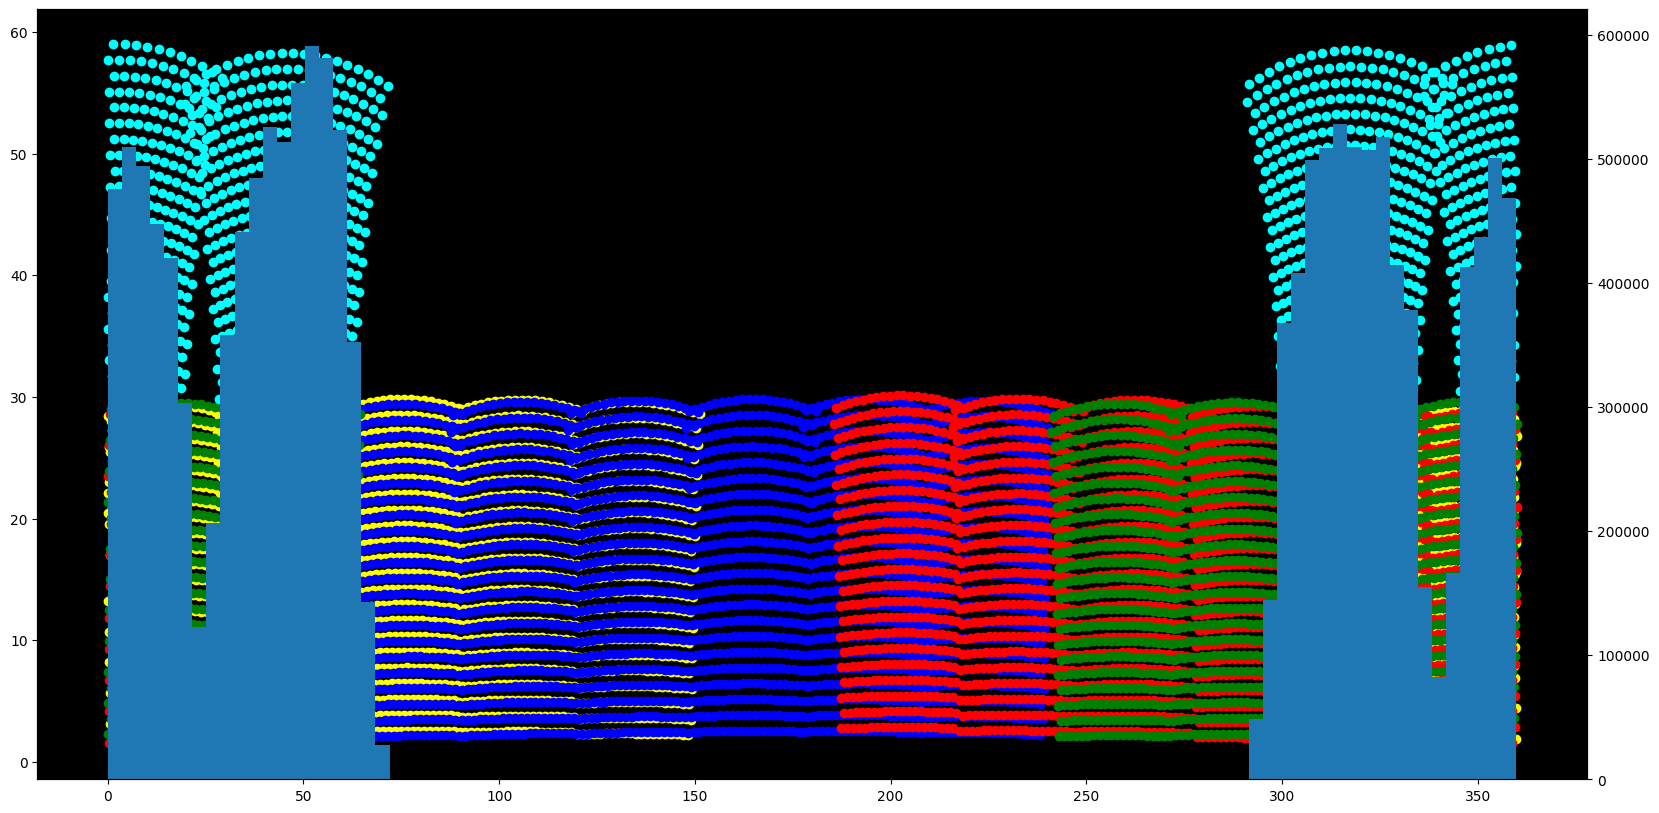

In [9]:
colors = ['yellow','blue','red','green','cyan']
plt.figure(figsize = (20,10))
plt.gca().set_facecolor('black')
for iEye in range(1,6):
    Mask = AllPossiblePixelDirections.EyeID == iEye
    Thetas = AllPossiblePixelDirections.Theta[Mask]
    Phis   = AllPossiblePixelDirections.Phi[Mask]
    plt.scatter(Phis,Thetas,c = colors[iEye-1])
    
ax2 = plt.gca().twinx()
CO_BackwallAngle = 243.0219
HE_BackwallAngle = 273.0
AllThetas = Dataset.get_pixel_values('Theta')
# plt.hist(AllThetas,bins=100)
AllPhis   = Dataset.get_pixel_values('Phi')
X = AllPhis+HE_BackwallAngle
X[X>360] -= 360
ax2.hist(X,bins=100)
plt.show()

In [10]:
event_class_labels = {
    0: 'Shower Candidate',
    1: 'Close Shower',
    2: 'Horizontal Shower',
    3: 'Large Event',
    4: 'Muon + Noise',
    5: 'Long Muon',
    6: 'Noise',
    7: 'Muon'
}

In [11]:
All_Event_Classes = Dataset.get_values('Event_Class').numpy()

for i in range(8):
    mask = All_Event_Classes == i
    print(f'Event Class {event_class_labels[i]} : {(np.sum(mask)/len(mask)*100):.3f} % events')

Event Class Shower Candidate : 10.114 % events
Event Class Close Shower : 32.292 % events
Event Class Horizontal Shower : 0.590 % events
Event Class Large Event : 0.001 % events
Event Class Muon + Noise : 36.433 % events
Event Class Long Muon : 11.020 % events
Event Class Noise : 1.445 % events
Event Class Muon : 8.103 % events


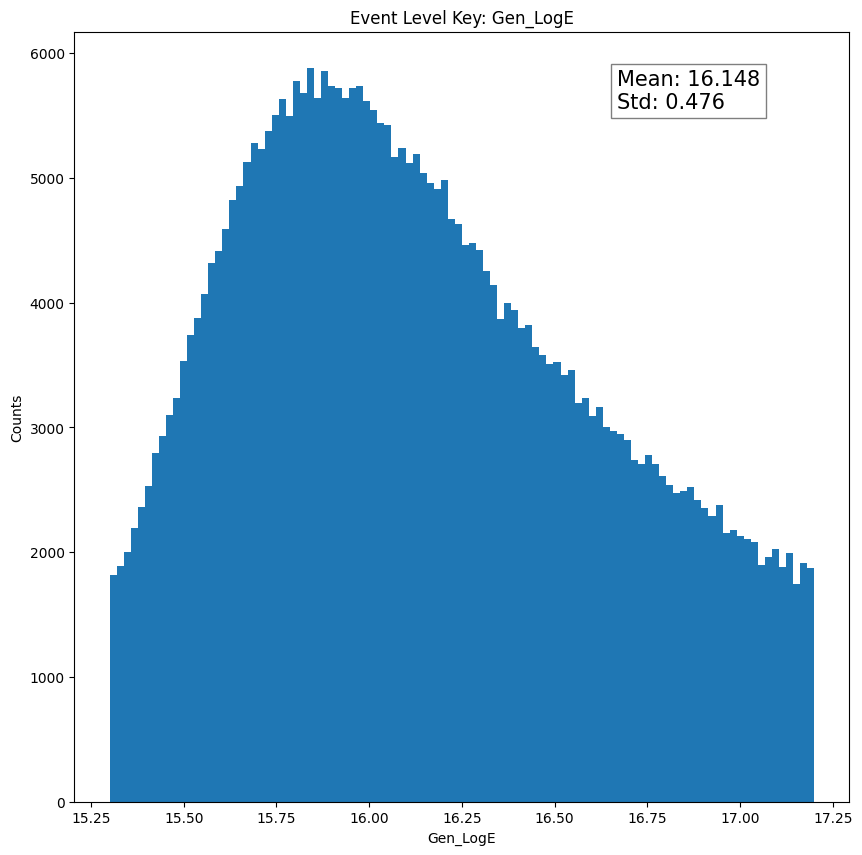

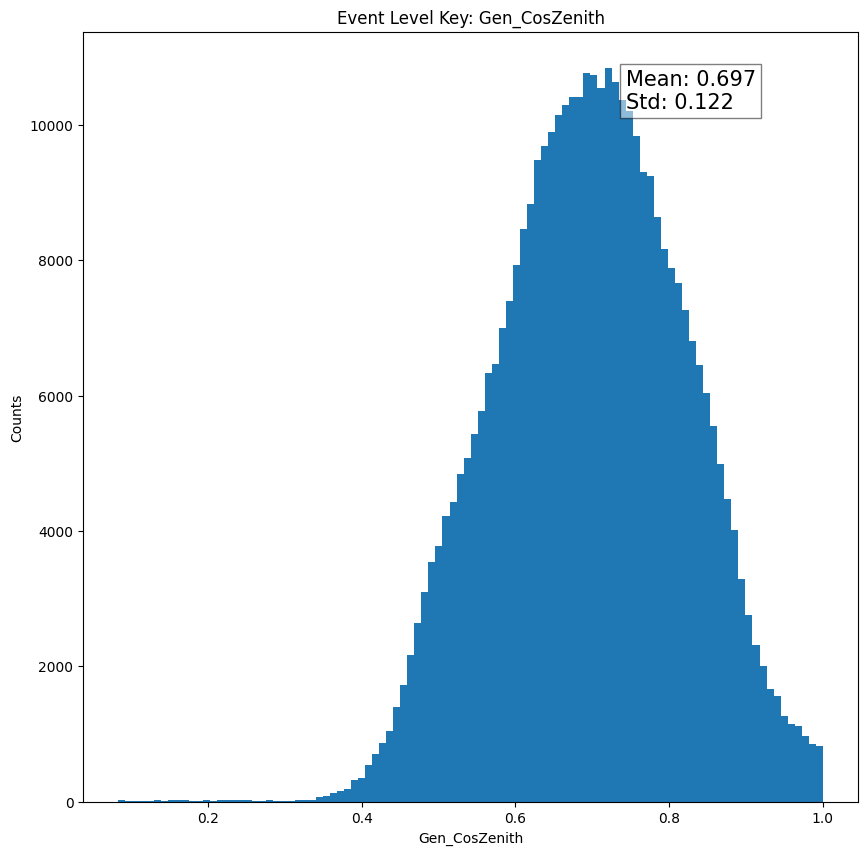

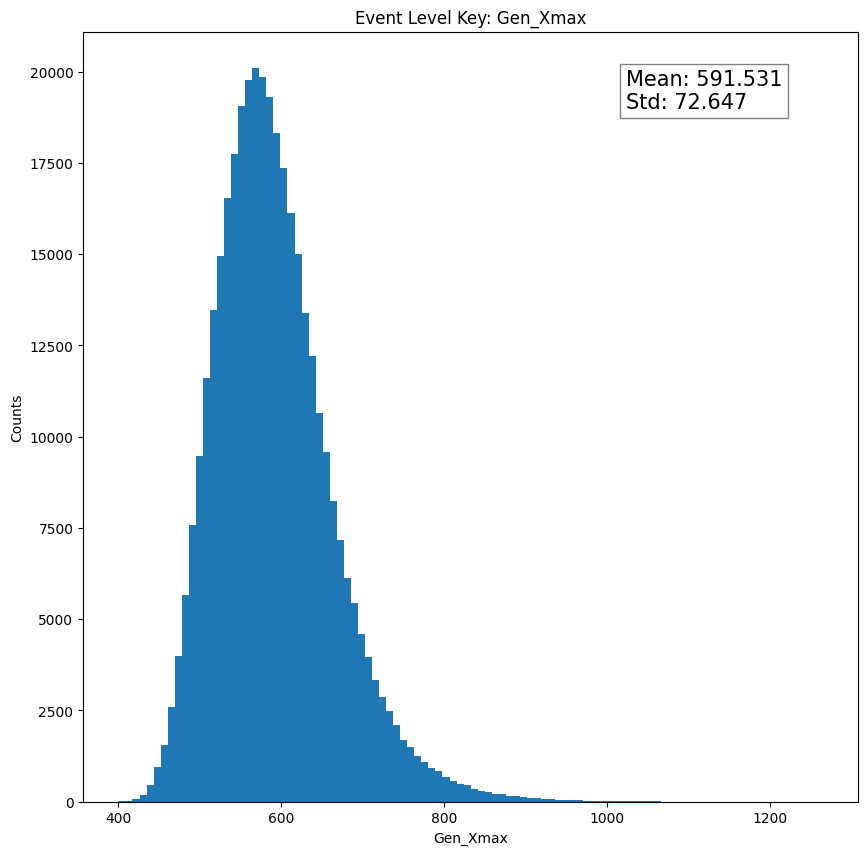

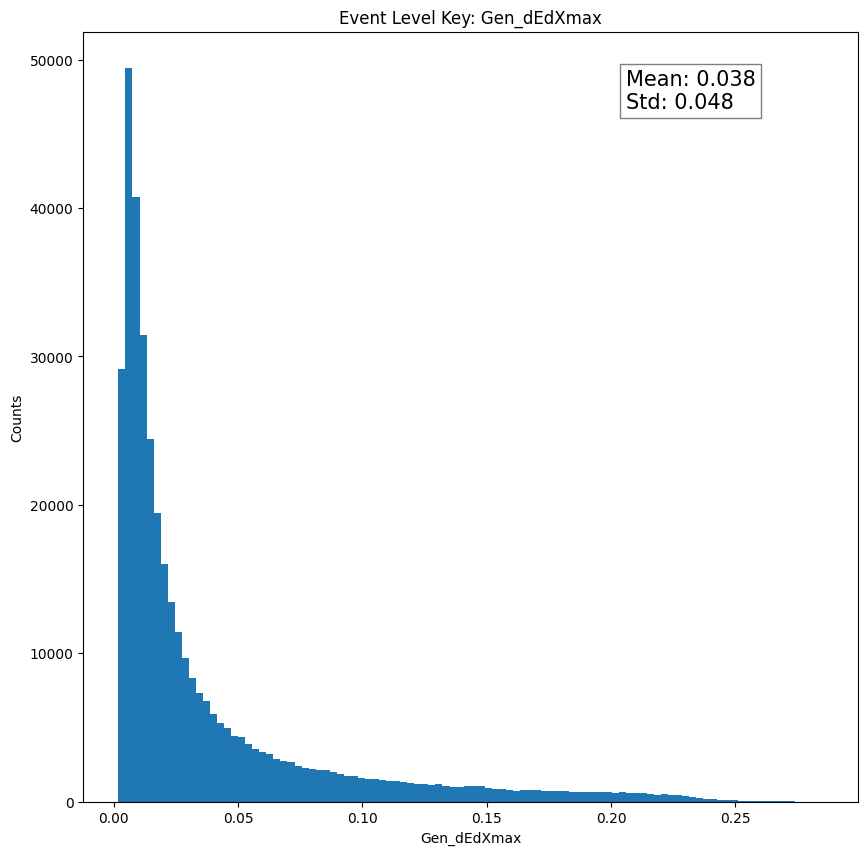

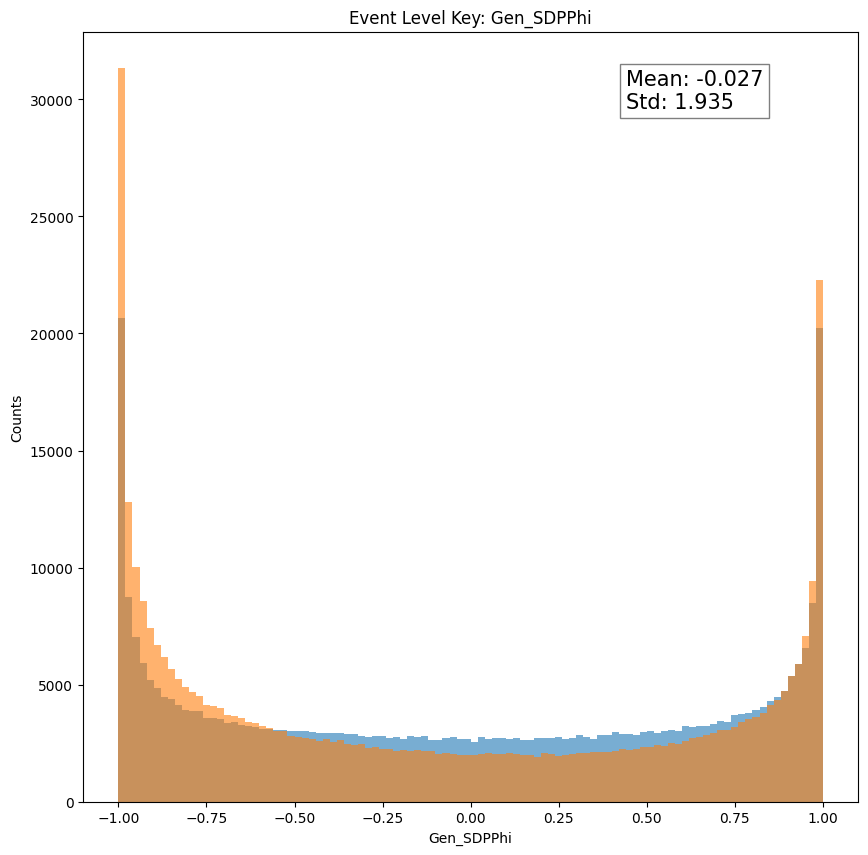

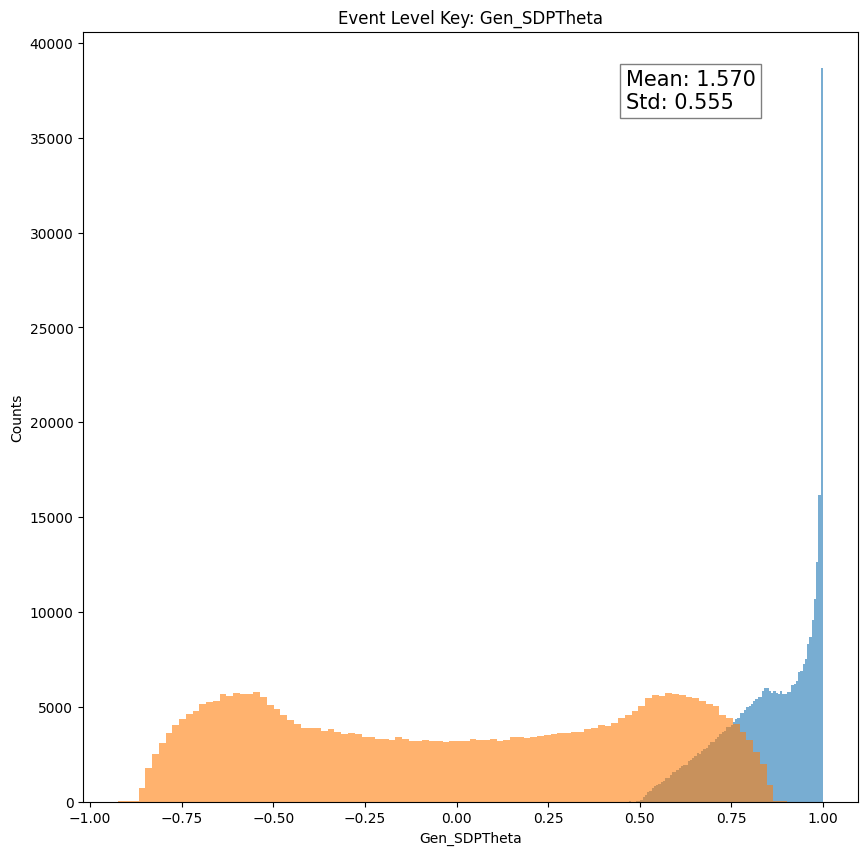

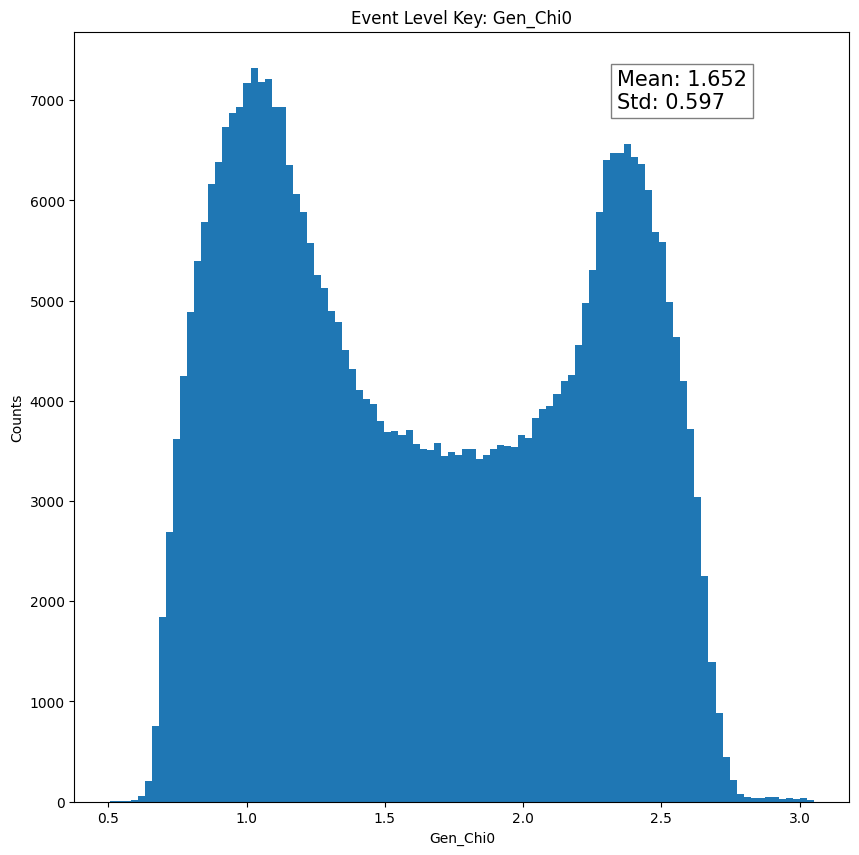

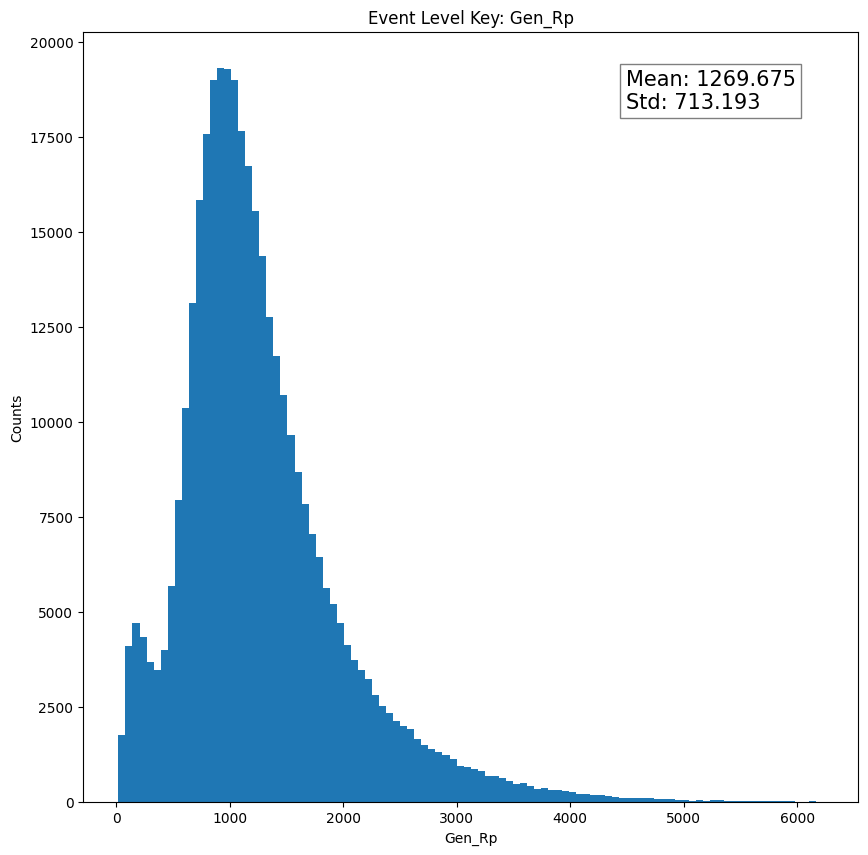

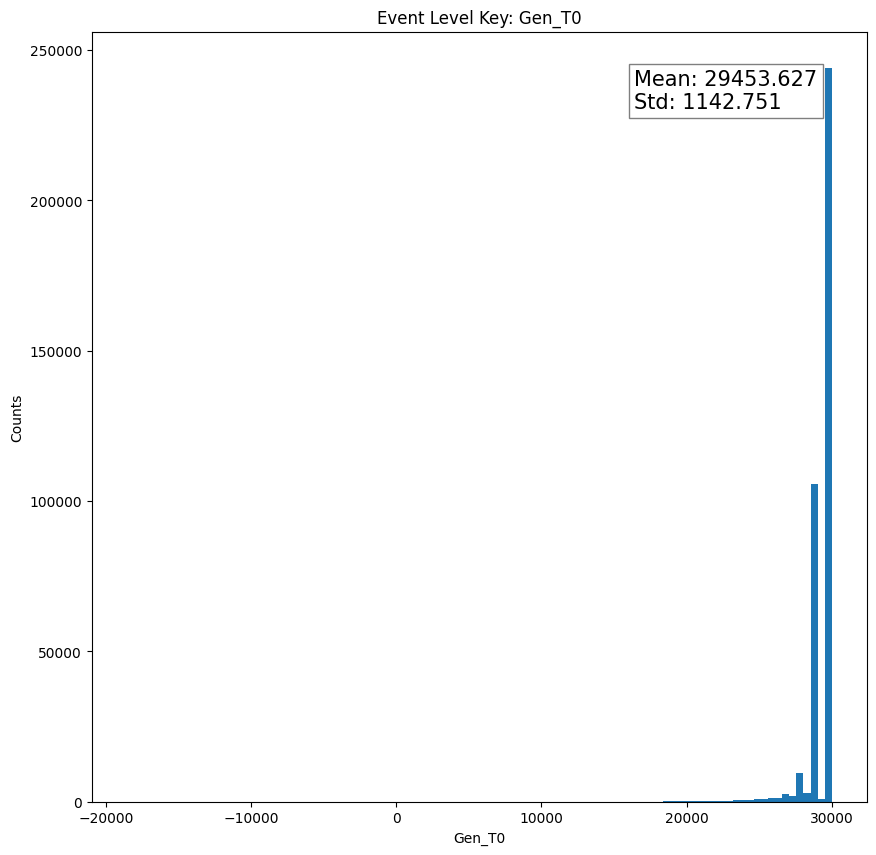

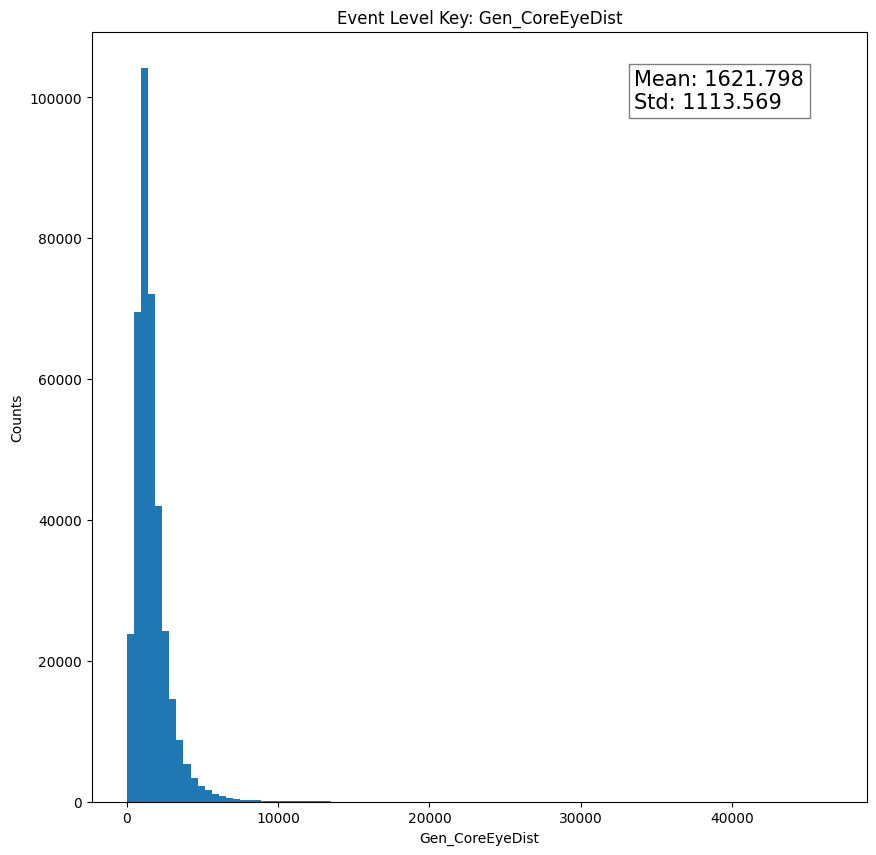

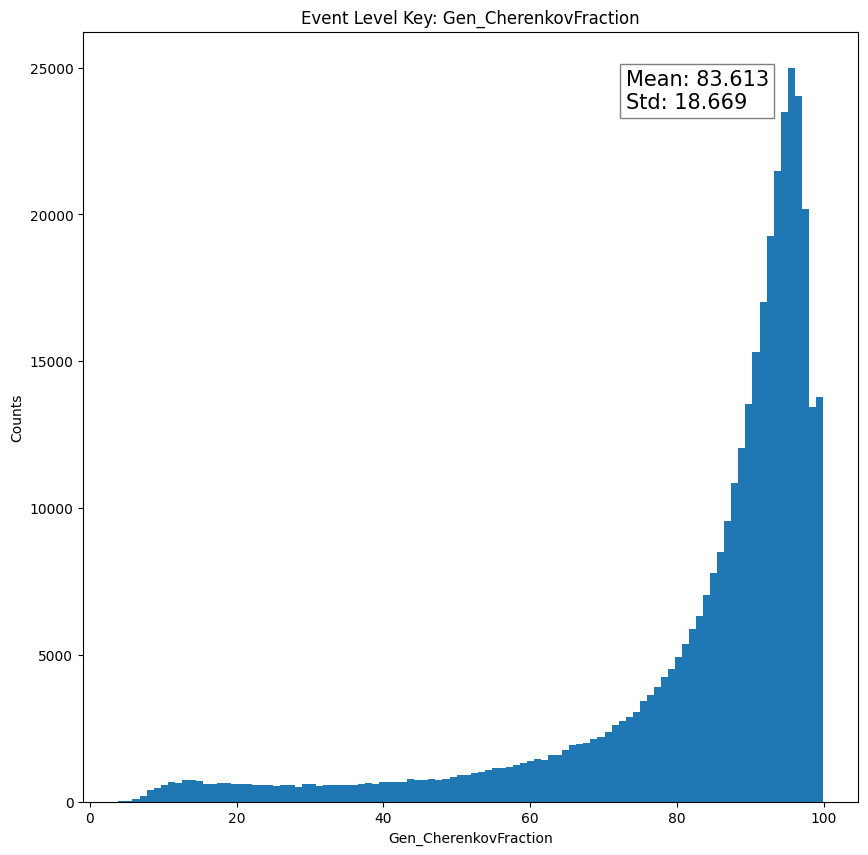

In [16]:
for key in Dataset.Event_level_keys.keys():
    if 'Gen' in key:
        All_Values = Dataset.get_values(key).numpy()

        plt.figure(figsize=(10,10))
        if 'SDP' in key:
            plt.hist(np.sin(All_Values),bins = 100,alpha = 0.6)
            plt.hist(np.cos(All_Values),bins = 100,alpha = 0.6)
        else:

            plt.hist(All_Values,bins=100)
        plt.title(f'Event Level Key: {key}')
        plt.xlabel(key)
        plt.ylabel('Counts')
        plt.text(0.7,0.9,f'Mean: {np.mean(All_Values):.3f}\nStd: {np.std(All_Values):.3f}',transform=plt.gca().transAxes,fontsize=15,bbox=dict(facecolor='white', alpha=0.5))
        plt.show()
        

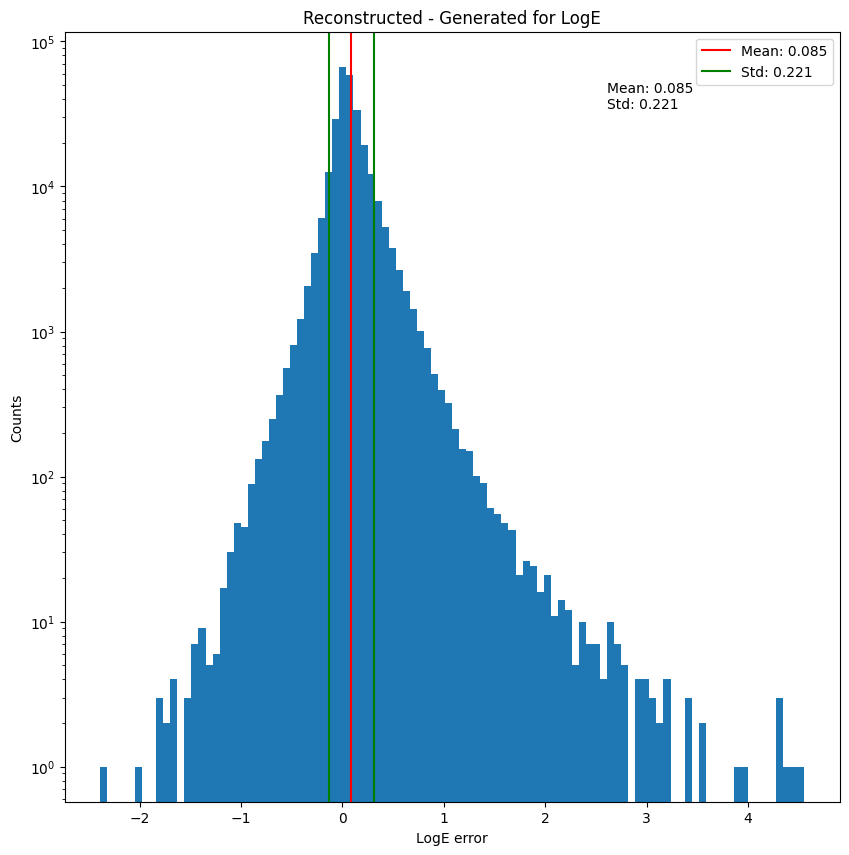

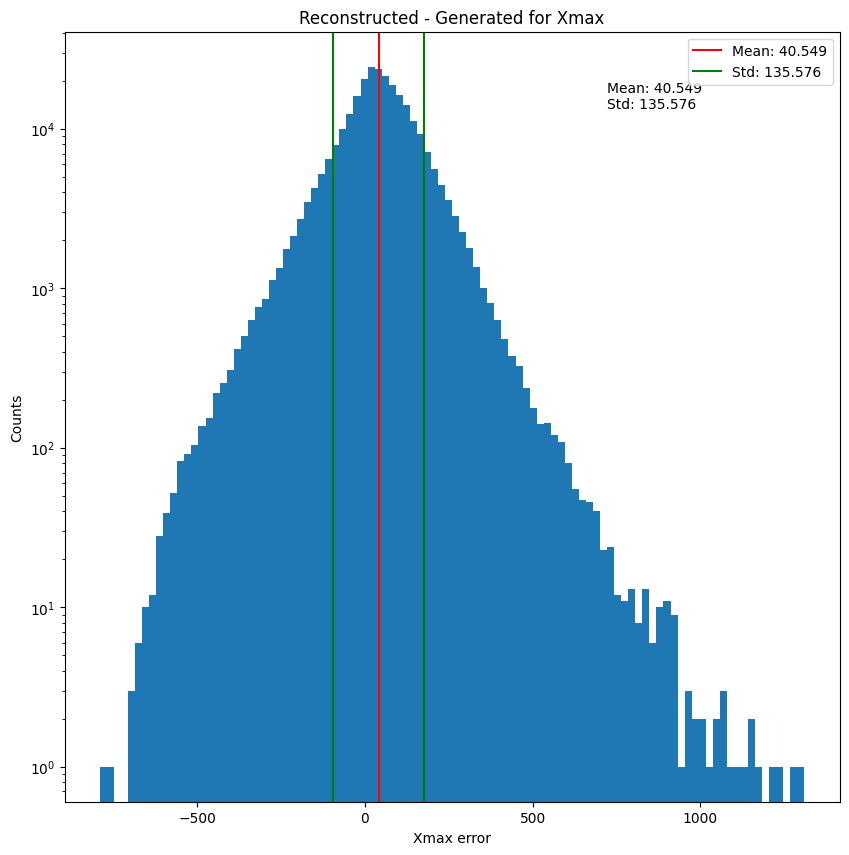

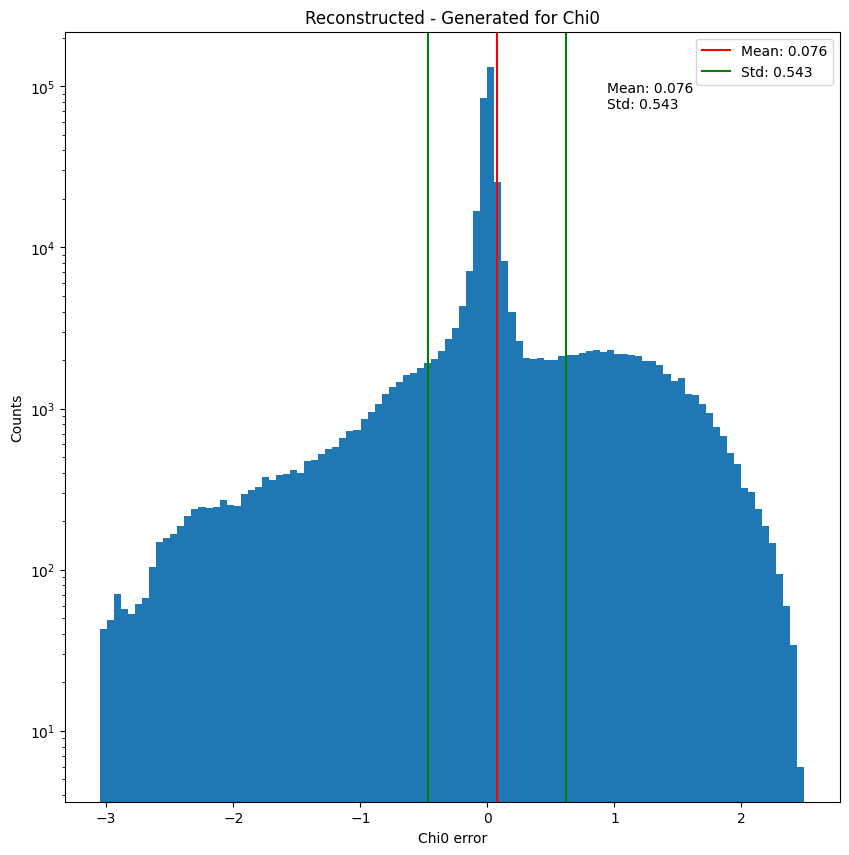

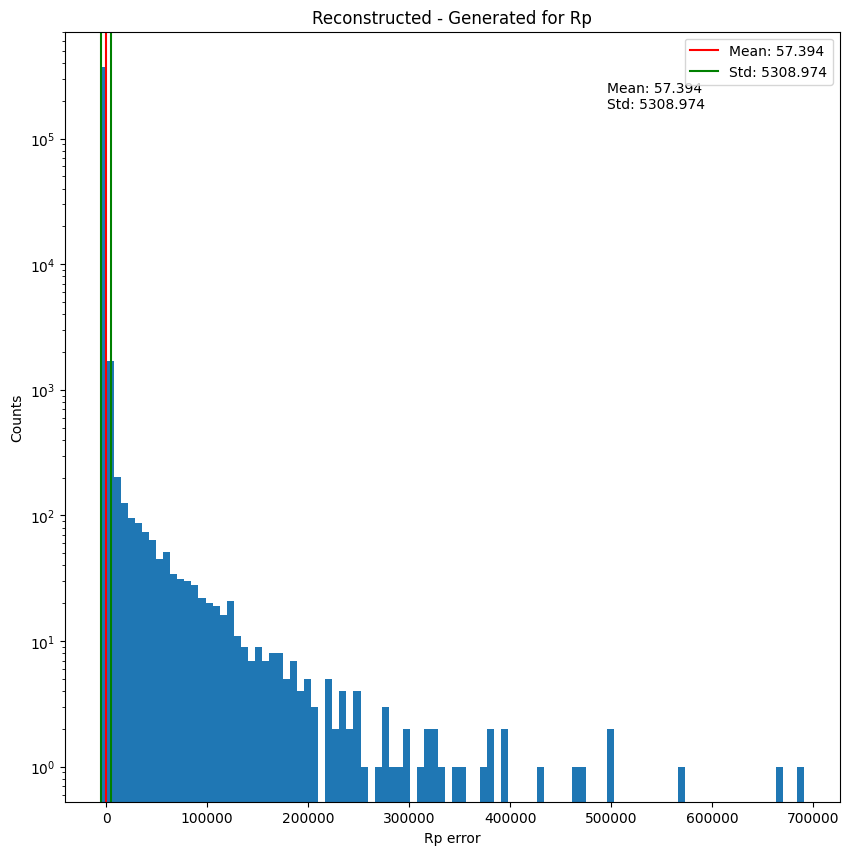

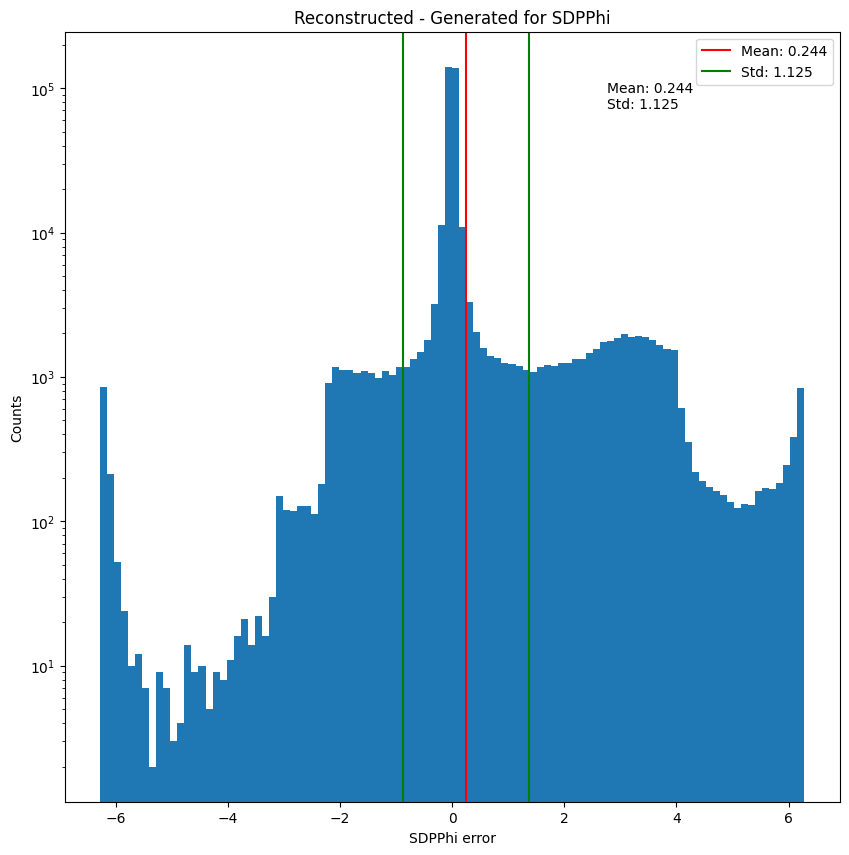

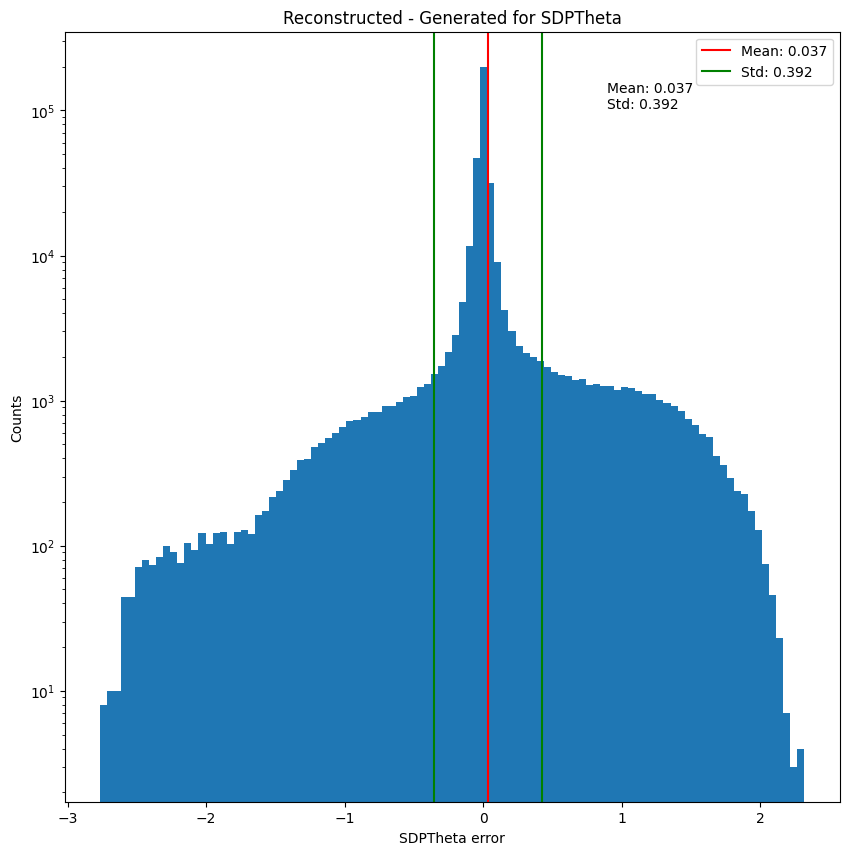

In [14]:
Vars = ['LogE','Xmax','Chi0','Rp','SDPPhi','SDPTheta']
for key in Vars:
    All_GenValues = Dataset.get_values(f'Gen_{key}').numpy()
    All_RecValues = Dataset.get_values(f'Rec_{key}').numpy()
    if key == 'Xmax':
        All_GenValues = All_GenValues[All_RecValues>0]
        All_RecValues = All_RecValues[All_RecValues>0]

    X = All_RecValues - All_GenValues
    BadMask = np.isnan(X) | np.isinf(X)
    X = X[~BadMask]
    mean = np.mean(X)
    std = np.std(X)
    plt.figure(figsize=(10,10))
    plt.hist(X,bins=100)
    plt.title(f'Reconstructed - Generated for {key}')
    plt.xlabel(f'{key} error')
    plt.ylabel('Counts')
    plt.axvline(mean,color='red',label=f'Mean: {mean:.3f}')
    plt.axvline(mean+std,color='green',label=f'Std: {std:.3f}')
    plt.axvline(mean-std,color='green')
    plt.text(0.7,0.9,f'Mean: {mean:.3f}\nStd: {std:.3f}',transform=plt.gca().transAxes)
    plt.legend()
    plt.yscale('log')
    plt.show()
